# The Long short-term memory (LSTM)

In [2]:
import os
import numpy as np
import pandas as pd
import music21 
import pickle
import tensorflow as tf

from matplotlib import pyplot as plt
from music21 import *
from tensorflow import keras
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
from keras.callbacks import ModelCheckpoint

In [5]:
src_dir = './datasets/'
song_list = os.listdir(src_dir)

In [6]:
streams = []
# Load and make list of stream objects
for song in song_list:
    stream = converter.parse(src_dir+song)
    streams.append(stream)

In [7]:
# Define function to test whether stream is monophonic
def monophonic(stream):
    try:
        length = len(instrument.partitionByInstrument(stream).parts)
    except:
        length = 0
    return length == 1

In [8]:
streams = [stream for stream in streams if monophonic(stream)]

In [9]:
notes = []
for stream in streams:
    notes_to_parse = None
    parts = instrument.partitionByInstrument(stream)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
        
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

### Generating Input and Output Sequences

Next, we will create an array of input and output sequences to train our model. Each input sequence will consist of 100 notes, while the output array stores the 101st note for the corresponding input sequence. So, the objective of the model will be to predict the 101st note of the input sequence of notes.

In [10]:
def prepare_sequences(notes): 
    sequence_length = 100
    n_vocab = len(set(notes))

    # Extract the unique pitches in the list of notes.
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i: i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    
    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = tf.keras.utils.to_categorical(network_output)
    
    return (network_input, network_output)

In [12]:
network_input, network_output = prepare_sequences(notes)

In [15]:
n_vocab = len(set(notes))

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=network_input.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 196)              

In [21]:
batch_size = 32
epochs = 200

Warning: Training duration: ~5h

In [22]:
# Create checkpoint to save the best model weights.
filepath = 'lstm.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
history = model.fit(network_input, network_output, epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])

Epoch 1/200
438/438 [==============================] - 80s 141ms/step - loss: 4.0361 - accuracy: 0.0550
Epoch 2/200
438/438 [==============================] - 57s 130ms/step - loss: 3.7737 - accuracy: 0.0676
Epoch 3/200
438/438 [==============================] - 58s 133ms/step - loss: 3.7275 - accuracy: 0.0747
Epoch 4/200
438/438 [==============================] - 60s 138ms/step - loss: 3.7037 - accuracy: 0.0777
Epoch 5/200
438/438 [==============================] - 60s 137ms/step - loss: 3.6798 - accuracy: 0.0764
Epoch 6/200
438/438 [==============================] - 58s 133ms/step - loss: 3.6386 - accuracy: 0.0879
Epoch 7/200
438/438 [==============================] - 59s 134ms/step - loss: 3.5558 - accuracy: 0.0971
Epoch 8/200
438/438 [==============================] - 58s 134ms/step - loss: 3.4744 - accuracy: 0.1077
Epoch 9/200
438/438 [==============================] - 59s 135ms/step - loss: 3.3947 - accuracy: 0.1236
Epoch 10/200
438/438 [==============================] - 60s 136m

438/438 [==============================] - 58s 132ms/step - loss: 0.0990 - accuracy: 0.9722
Epoch 80/200
438/438 [==============================] - 58s 131ms/step - loss: 0.0934 - accuracy: 0.9752
Epoch 81/200
438/438 [==============================] - 60s 137ms/step - loss: 0.1023 - accuracy: 0.9726
Epoch 82/200
438/438 [==============================] - 61s 140ms/step - loss: 0.1008 - accuracy: 0.9720
Epoch 83/200
438/438 [==============================] - 58s 133ms/step - loss: 0.0941 - accuracy: 0.9745
Epoch 84/200
438/438 [==============================] - 57s 131ms/step - loss: 0.0740 - accuracy: 0.9780
Epoch 85/200
438/438 [==============================] - 57s 131ms/step - loss: 0.0903 - accuracy: 0.9756
Epoch 86/200
438/438 [==============================] - 57s 131ms/step - loss: 0.1076 - accuracy: 0.9718
Epoch 87/200
438/438 [==============================] - 63s 143ms/step - loss: 0.1013 - accuracy: 0.9748
Epoch 88/200
438/438 [==============================] - 58s 133ms/st

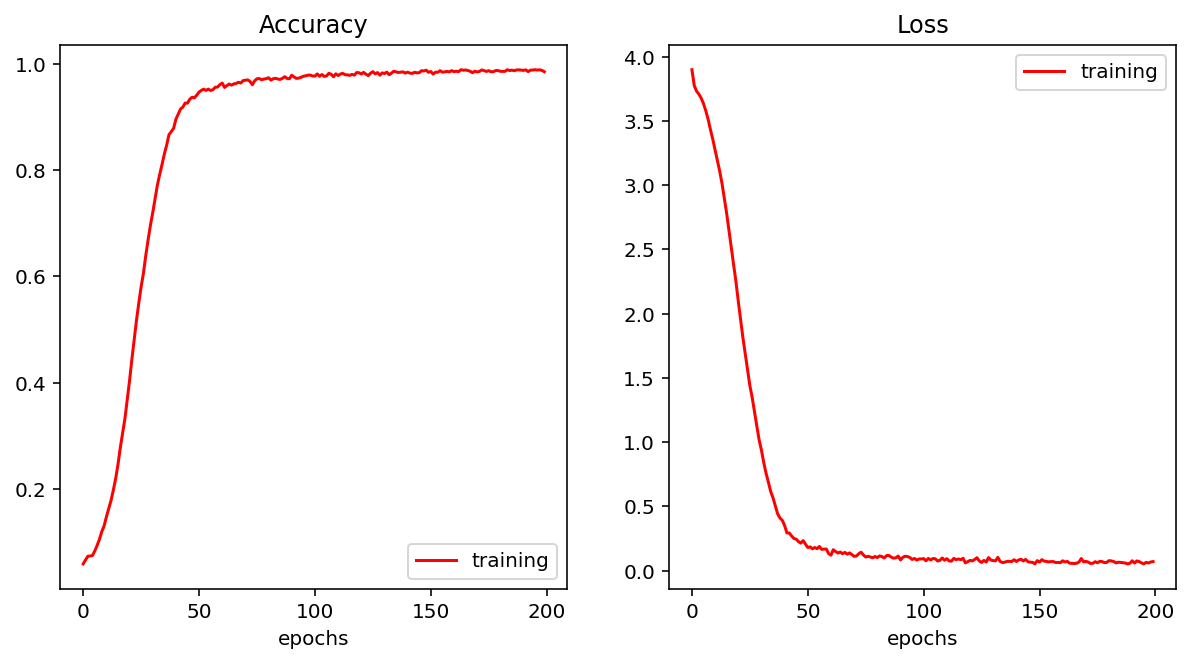

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
accuracy = history.history['accuracy']
plt.plot(range(epochs), accuracy, color='red', label='training')
plt.xlabel('epochs')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Loss')
loss = history.history['loss']
plt.plot(range(epochs), loss, color='red', label='training')
plt.xlabel('epochs')
plt.legend(loc='best')
    
plt.show()

In [26]:
model.save('./lstm.h5')

## Generate guitar midi file

In [29]:
model.load_weights('./lstm.hdf5')

### Generate notes from the neural network based on a sequence of notes

In [30]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    # Pick a random integer
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    
    # pick a random sequence from the input as a starting point for the prediction
    pattern = list(network_input[start])
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(np.asarray(prediction_input, 'float32'), batch_size = batch_size, verbose=0)
        
        # Predicted output is the argmax(P(h|D))
        index = np.argmax(prediction)
        # Mapping the predicted interger back to the corresponding note
        result = int_to_note[index]
        # Storing the predicted output
        prediction_output.append(result)

        pattern.append(index)
        # Next input to the model
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [32]:
pitchnames = sorted(set(item for item in notes))
prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)

### Convert the output from the prediction to notes and create a midi file from the notes

In [33]:
def create_midi(prediction_output):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.AcousticGuitar()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.AcousticGuitar()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = music21.stream.Stream(output_notes)
    midi_stream.write('midi', fp='./generated/lstm1.mid')

In [34]:
create_midi(prediction_output)

### Play midi file

In [35]:
def play_midi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    stream = midi.translate.midiFileToStream(mf)
    stream.show('midi')

In [59]:
play_midi('./generated/lstm1.mid')